# Human Activity Recognition

### Step 1: Download the dataset from link 

https://www.utwente.nl/en/eemcs/ps/dataset-folder/sensors-activity-recognition-dataset-shoaib.rar


In [ ]:
!pip install tensorflow-gpu==2.3.0
!pip install keras==2.4.3
!pip install numpy==1.19.5
!pip install matplotlib==3.3.3

In [1]:
import urllib.request

print('Downloading dataset')

url = 'https://www.utwente.nl/en/eemcs/ps/dataset-folder/sensors-activity-recognition-dataset-shoaib.rar'
urllib.request.urlretrieve(url, 'HAR_dataset.rar')

print('Download completed')

Download completed


### Step 2: Extract in the working directory


In [2]:
!pip3 install pyunpack
!pip3 install patool
from pyunpack import Archive
Archive('HAR_dataset.rar').extractall('.')

     |████████████████████████████████| 81kB 5.5MB/s 


### Step 3: Download Libraries


In [3]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [4]:
# import libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [5]:
path='/content/DataSet/'
files=[file for file in os.listdir(path) if file.endswith('.csv')]
files

['Participant_3.csv',
 'Participant_2.csv',
 'Participant_7.csv',
 'Participant_4.csv',
 'Participant_1.csv',
 'Participant_6.csv',
 'Participant_8.csv',
 'Participant_10.csv',
 'Participant_5.csv',
 'Participant_9.csv']

In [6]:
# load a file into memory
df=pd.read_csv(path+files[0],header=1)
df.head()

,time_stamp,Ax,Ay,Az,Lx,Ly,Lz,Gx,Gy,Gz,Mx,My,Mz,Unnamed: 13,time_stamp.1,Ax.1,Ay.1,Az.1,Lx.1,Ly.1,Lz.1,Gx.1,Gy.1,Gz.1,Mx.1,My.1,Mz.1,Unnamed: 27,time_stamp.2,Ax.2,Ay.2,Az.2,Lx.2,Ly.2,Lz.2,Gx.2,Gy.2,Gz.2,Mx.2,My.2,Mz.2,Unnamed: 41,time_stamp.3,Ax.3,Ay.3,Az.3,Lx.3,Ly.3,Lz.3,Gx.3,Gy.3,Gz.3,Mx.3,My.3,Mz.3,Unnamed: 55,time_stamp.4,Ax.4,Ay.4,Az.4,Lx.4,Ly.4,Lz.4,Gx.4,Gy.4,Gz.4,Mx.4,My.4,Mz.4,Unnamed: 69
0,1.390000e+12,-0.74912,-10.665,-0.258790,-1.9316,-1.0296,-1.6503,0.813060,-0.86285,-0.70372,17.34,41.52,-0.54,NaN,1.390000e+12,1.70250,-8.7715,1.48460,1.642800,1.03150,1.74340,1.15730,0.10965,0.35400,8.16,38.04,18.66,NaN,1.390000e+12,3.2825,-13.2390,-2.6696,3.5343,-3.4510,-2.12030,-0.046426,-0.26909,0.089492,-1.44,38.34,18.60,NaN,1.390000e+12,1.25310,-12.7350,-0.99429,1.02640,-1.96920,-0.002784,0.210140,-0.39431,-0.59712,-16.62,39.24,8.40,NaN,1.390000e+12,6.5378,-1.22580,-1.7706,-2.9075,-0.83069,0.837160,1.12280,-1.05890,0.292300,-90.90,-0.12,1.68,walking
1,1.390000e+12,-0.65378,-10.719,-0.272410,-1.9647,-1.1182,-1.7796,0.682640,-0.75411,-0.69852,16.98,41.52,-1.44,NaN,1.390000e+12,1.79790,-8.9622,0.92618,1.755300,0.84333,1.06870,1.11540,0.85155,0.24129,8.34,38.28,18.18,NaN,1.390000e+12,3.8001,-15.6770,-2.6151,3.9275,-5.8911,-1.99080,-0.165540,-0.34819,0.039095,-0.18,38.64,18.42,NaN,1.390000e+12,2.12480,-9.9292,-1.18500,1.52290,-0.18756,-0.232130,0.283140,-0.59040,-0.56383,-16.44,39.36,8.40,NaN,1.390000e+12,5.9930,-1.41650,-2.2474,-3.4204,-0.97337,0.466220,0.88820,-1.19120,0.003665,-90.48,0.12,2.04,walking
2,1.390000e+12,-0.57205,-11.264,-0.040861,-2.0455,-1.7017,-1.6411,0.426990,-0.41111,-0.57482,16.08,41.94,-3.18,NaN,1.390000e+12,0.89894,-9.5887,-0.14982,0.911520,0.21656,-0.31297,0.99052,0.88331,0.29413,9.00,38.70,16.86,NaN,1.390000e+12,3.4732,-13.4710,-2.5742,3.5439,-3.6883,-1.88620,-0.284660,-0.48594,-0.032987,0.42,38.82,18.18,NaN,1.390000e+12,2.26100,-9.3299,-1.19860,1.56840,0.40960,-0.286350,0.188760,-1.16030,-0.39309,-16.38,39.24,8.58,NaN,1.390000e+12,5.0940,-1.75700,-2.8330,-4.2503,-1.25150,0.099374,0.79596,-1.03660,0.008247,-90.12,0.42,2.40,walking
3,1.390000e+12,-0.91256,-11.087,-0.449470,-2.4627,-1.5430,-2.0864,0.238540,-0.18906,-0.43005,15.66,41.94,-3.72,NaN,1.390000e+12,0.78998,-9.6977,-0.85808,0.852810,0.10292,-1.19650,1.08860,0.68600,0.32162,9.30,38.94,16.14,NaN,1.390000e+12,3.1191,-11.6450,-2.4108,3.1384,-1.8663,-1.67610,-0.365910,-0.51465,-0.227240,0.90,38.82,18.00,NaN,1.390000e+12,2.11120,-9.4389,-1.02150,1.37660,0.29835,-0.117700,-0.058948,-1.48530,-0.39798,-16.44,39.24,8.64,NaN,1.390000e+12,4.6309,-1.15770,-3.6775,-4.6362,-0.57621,-0.522680,0.52290,-0.49877,0.060170,-89.52,1.14,3.30,walking
4,1.390000e+12,-1.32120,-11.319,0.231550,-2.9057,-1.7786,-1.3965,0.050396,-0.19059,-0.27855,15.00,41.88,-5.04,NaN,1.390000e+12,-0.16344,-10.1060,-1.67530,-0.000045,-0.31884,-2.26630,1.03360,0.59407,0.40714,9.66,39.36,14.70,NaN,1.390000e+12,2.4925,-8.7306,-1.8387,2.3566,1.0372,-0.97764,-0.462420,-0.48778,-0.779460,1.80,39.06,17.94,NaN,1.390000e+12,0.64016,-10.0930,-0.47671,-0.17667,-0.36578,0.467070,-0.279470,-1.76540,-0.53542,-16.44,39.12,8.94,NaN,1.390000e+12,5.0668,-0.84446,-3.8273,-4.1886,-0.24044,-0.642460,0.29260,0.39554,0.081245,-89.16,1.38,3.78,walking


In [7]:
df['Unnamed: 69'].unique()

array(['walking', 'standing', 'jogging', 'sitting', 'biking', 'upstairs',
       'downstairs'], dtype=object)

## Visualize the difference in change in values w.r.t activity

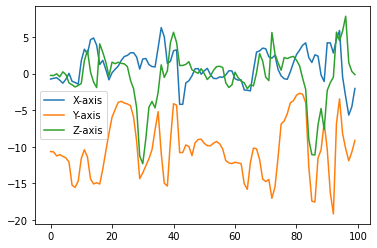

In [8]:
# change in values while walking

plt.plot(np.arange(0,100),df.Ax[df['Unnamed: 69']=="walking"][:100], label='X-axis')
plt.plot(np.arange(0,100),df.Ay[df['Unnamed: 69']=="walking"][:100], label='Y-axis')
plt.plot(np.arange(0,100),df.Az[df['Unnamed: 69']=="walking"][:100], label='Z-axis')
plt.legend()

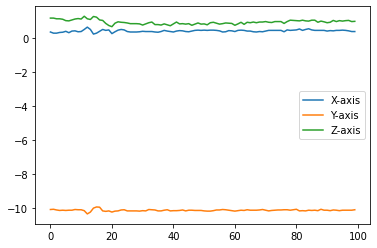

In [9]:
# change in values while standing

plt.plot(np.arange(0,100),df.Ax[df['Unnamed: 69']=="standing"][:100], label='X-axis')
plt.plot(np.arange(0,100),df.Ay[df['Unnamed: 69']=="standing"][:100], label='Y-axis')
plt.plot(np.arange(0,100),df.Az[df['Unnamed: 69']=="standing"][:100], label='Z-axis')
plt.legend()

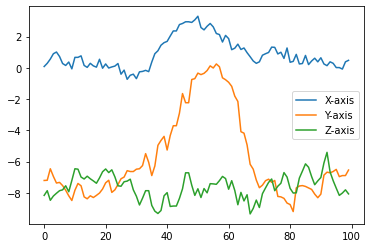

In [10]:
# change in values while biking

plt.plot(np.arange(0,100),df.Ax[df['Unnamed: 69']=="biking"][:100], label='X-axis')
plt.plot(np.arange(0,100),df.Ay[df['Unnamed: 69']=="biking"][:100], label='Y-axis')
plt.plot(np.arange(0,100),df.Az[df['Unnamed: 69']=="biking"][:100], label='Z-axis')
plt.legend()

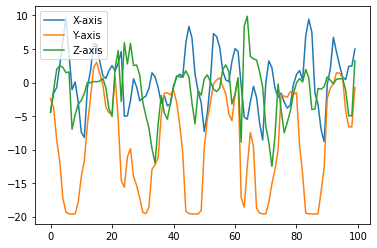

In [11]:
# change in values while jogging

plt.plot(np.arange(0,100),df.Ax[df['Unnamed: 69']=="jogging"][:100], label='X-axis')
plt.plot(np.arange(0,100),df.Ay[df['Unnamed: 69']=="jogging"][:100], label='Y-axis')
plt.plot(np.arange(0,100),df.Az[df['Unnamed: 69']=="jogging"][:100], label='Z-axis')
plt.legend()

## Load and concatenate all files into one dataframe

In [12]:
df=pd.DataFrame()

for file in files:
    df_temp=pd.read_csv(path+file,header=1)
    df=pd.concat([df,df_temp], sort=False)
df

,time_stamp,Ax,Ay,Az,Lx,Ly,Lz,Gx,Gy,Gz,Mx,My,Mz,Unnamed: 13,time_stamp.1,Ax.1,Ay.1,Az.1,Lx.1,Ly.1,Lz.1,Gx.1,Gy.1,Gz.1,Mx.1,My.1,Mz.1,Unnamed: 27,time_stamp.2,Ax.2,Ay.2,Az.2,Lx.2,Ly.2,Lz.2,Gx.2,Gy.2,Gz.2,Mx.2,My.2,Mz.2,Unnamed: 41,time_stamp.3,Ax.3,Ay.3,Az.3,Lx.3,Ly.3,Lz.3,Gx.3,Gy.3,Gz.3,Mx.3,My.3,Mz.3,Unnamed: 55,time_stamp.4,Ax.4,Ay.4,Az.4,Lx.4,Ly.4,Lz.4,Gx.4,Gy.4,Gz.4,Mx.4,My.4,Mz.4,Unnamed: 69
0,1.390000e+12,-0.74912,-10.6650,-0.258790,-1.931600,-1.029600,-1.650300,0.813060,-0.86285,-0.703720,17.34,41.52,-0.54,NaN,1.390000e+12,1.70250,-8.7715,1.484600,1.642800,1.03150,1.74340,1.15730,0.10965,0.354000,8.16,38.04,18.66,NaN,1.390000e+12,3.2825,-13.2390,-2.66960,3.5343,-3.4510,-2.120300,-0.046426,-0.26909,0.089492,-1.44,38.34,18.60,NaN,1.390000e+12,1.25310,-12.7350,-0.99429,1.02640,-1.96920,-0.002784,0.210140,-0.394310,-0.59712,-16.62,39.24,8.40,NaN,1.390000e+12,6.5378,-1.22580,-1.7706,-2.90750,-0.83069,0.837160,1.12280,-1.05890,0.292300,-90.90,-0.12,1.68,walking
1,1.390000e+12,-0.65378,-10.7190,-0.272410,-1.964700,-1.118200,-1.779600,0.682640,-0.75411,-0.698520,16.98,41.52,-1.44,NaN,1.390000e+12,1.79790,-8.9622,0.926180,1.755300,0.84333,1.06870,1.11540,0.85155,0.241290,8.34,38.28,18.18,NaN,1.390000e+12,3.8001,-15.6770,-2.61510,3.9275,-5.8911,-1.990800,-0.165540,-0.34819,0.039095,-0.18,38.64,18.42,NaN,1.390000e+12,2.12480,-9.9292,-1.18500,1.52290,-0.18756,-0.232130,0.283140,-0.590400,-0.56383,-16.44,39.36,8.40,NaN,1.390000e+12,5.9930,-1.41650,-2.2474,-3.42040,-0.97337,0.466220,0.88820,-1.19120,0.003665,-90.48,0.12,2.04,walking
2,1.390000e+12,-0.57205,-11.2640,-0.040861,-2.045500,-1.701700,-1.641100,0.426990,-0.41111,-0.574820,16.08,41.94,-3.18,NaN,1.390000e+12,0.89894,-9.5887,-0.149820,0.911520,0.21656,-0.31297,0.99052,0.88331,0.294130,9.00,38.70,16.86,NaN,1.390000e+12,3.4732,-13.4710,-2.57420,3.5439,-3.6883,-1.886200,-0.284660,-0.48594,-0.032987,0.42,38.82,18.18,NaN,1.390000e+12,2.26100,-9.3299,-1.19860,1.56840,0.40960,-0.286350,0.188760,-1.160300,-0.39309,-16.38,39.24,8.58,NaN,1.390000e+12,5.0940,-1.75700,-2.8330,-4.25030,-1.25150,0.099374,0.79596,-1.03660,0.008247,-90.12,0.42,2.40,walking
3,1.390000e+12,-0.91256,-11.0870,-0.449470,-2.462700,-1.543000,-2.086400,0.238540,-0.18906,-0.430050,15.66,41.94,-3.72,NaN,1.390000e+12,0.78998,-9.6977,-0.858080,0.852810,0.10292,-1.19650,1.08860,0.68600,0.321620,9.30,38.94,16.14,NaN,1.390000e+12,3.1191,-11.6450,-2.41080,3.1384,-1.8663,-1.676100,-0.365910,-0.51465,-0.227240,0.90,38.82,18.00,NaN,1.390000e+12,2.11120,-9.4389,-1.02150,1.37660,0.29835,-0.117700,-0.058948,-1.485300,-0.39798,-16.44,39.24,8.64,NaN,1.390000e+12,4.6309,-1.15770,-3.6775,-4.63620,-0.57621,-0.522680,0.52290,-0.49877,0.060170,-89.52,1.14,3.30,walking
4,1.390000e+12,-1.32120,-11.3190,0.231550,-2.905700,-1.778600,-1.396500,0.050396,-0.19059,-0.278550,15.00,41.88,-5.04,NaN,1.390000e+12,-0.16344,-10.1060,-1.675300,-0.000045,-0.31884,-2.26630,1.03360,0.59407,0.407140,9.66,39.36,14.70,NaN,1.390000e+12,2.4925,-8.7306,-1.83870,2.3566,1.0372,-0.977640,-0.462420,-0.48778,-0.779460,1.80,39.06,17.94,NaN,1.390000e+12,0.64016,-10.0930,-0.47671,-0.17667,-0.36578,0.467070,-0.279470,-1.765400,-0.53542,-16.44,39.12,8.94,NaN,1.390000e+12,5.0668,-0.84446,-3.8273,-4.18860,-0.24044,-0.642460,0.29260,0.39554,0.081245,-89.16,1.38,3.78,walking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62995,1.390000e+12,-3.11910,-9.0167,-1.511900,2.289100,-0.836530,-1.422500,0.430050,-0.50946,0.111790,15.30,27.24,-15.42,NaN,1.390000e+12,3.86820,-9.9020,0.354130,3.558700,-0.18493,-0.93169,-0.20617,0.28253,0.230910,29.34,47.94,0.42,NaN,1.390000e+12,4.4130,-7.4095,0.42223,1.7435,2.0216,0.737300,-0.706470,1.86830,1.323400,29.46,44.22,-7.08,NaN,1.390000e+12,2.47890,-8.5808,-2.65600,1.96530,1.04470,-0.851430,0.082772,-0.083078,0.

In [13]:
for i in df.columns:
    print(i)

time_stamp
Ax
Ay
Az
Lx
Ly
Lz
Gx
Gy
Gz
Mx
My
Mz
Unnamed: 13
time_stamp.1
Ax.1
Ay.1
Az.1
Lx.1
Ly.1
Lz.1
Gx.1
Gy.1
Gz.1
Mx.1
My.1
Mz.1
Unnamed: 27
time_stamp.2
Ax.2
Ay.2
Az.2
Lx.2
Ly.2
Lz.2
Gx.2
Gy.2
Gz.2
Mx.2
My.2
Mz.2
Unnamed: 41
time_stamp.3
Ax.3
Ay.3
Az.3
Lx.3
Ly.3
Lz.3
Gx.3
Gy.3
Gz.3
Mx.3
My.3
Mz.3
Unnamed: 55
time_stamp.4
Ax.4
Ay.4
Az.4
Lx.4
Ly.4
Lz.4
Gx.4
Gy.4
Gz.4
Mx.4
My.4
Mz.4
Unnamed: 69


In [14]:
# split out left and right pocket data

left_pocket = df[df.columns[1:10]]
left_pocket

,Ax,Ay,Az,Lx,Ly,Lz,Gx,Gy,Gz
0,-0.74912,-10.6650,-0.258790,-1.931600,-1.029600,-1.650300,0.813060,-0.86285,-0.703720
1,-0.65378,-10.7190,-0.272410,-1.964700,-1.118200,-1.779600,0.682640,-0.75411,-0.698520
2,-0.57205,-11.2640,-0.040861,-2.045500,-1.701700,-1.641100,0.426990,-0.41111,-0.574820
3,-0.91256,-11.0870,-0.449470,-2.462700,-1.543000,-2.086400,0.238540,-0.18906,-0.430050
4,-1.32120,-11.3190,0.231550,-2.905700,-1.778600,-1.396500,0.050396,-0.19059,-0.278550
...,...,...,...,...,...,...,...,...,...
62995,-3.11910,-9.0167,-1.511900,2.289100,-0.836530,-1.422500,0.430050,-0.50946,0.111790
62996,-4.56280,-7.5321,0.708260,0.843960,0.648940,0.615980,0.197920,-0.67959,-0.092546
62997,-5.40730,-7.8045,0.871700,-0.022973,0.389340,0.668480,0.193340,-0.65088,-0.208000
62998,-6.04740,-8.1177,0.258790,-0.695410,0.094103,-0.044593,0.188760,-0.50824,-0.164630


In [15]:
right_pocket = df[df.columns[15:24]]
right_pocket.columns=left_pocket.columns
right_pocket

,Ax,Ay,Az,Lx,Ly,Lz,Gx,Gy,Gz
0,1.70250,-8.7715,1.484600,1.642800,1.03150,1.74340,1.15730,0.10965,0.354000
1,1.79790,-8.9622,0.926180,1.755300,0.84333,1.06870,1.11540,0.85155,0.241290
2,0.89894,-9.5887,-0.149820,0.911520,0.21656,-0.31297,0.99052,0.88331,0.294130
3,0.78998,-9.6977,-0.858080,0.852810,0.10292,-1.19650,1.08860,0.68600,0.321620
4,-0.16344,-10.1060,-1.675300,-0.000045,-0.31884,-2.26630,1.03360,0.59407,0.407140
...,...,...,...,...,...,...,...,...,...
62995,3.86820,-9.9020,0.354130,3.558700,-0.18493,-0.93169,-0.20617,0.28253,0.230910
62996,3.94990,-9.5206,0.054481,3.630600,0.20627,-1.15210,-0.25137,0.32223,0.107210
62997,3.43230,-9.4798,-0.313270,3.091200,0.24997,-1.49070,-0.13531,0.25351,-0.073609
62998,2.43800,-9.5615,-0.858080,2.041800,0.17223,-1.98430,-0.16768,0.29963,-0.204330


In [16]:
# concatenate left and right split in one data frame

train_df=pd.concat([left_pocket,right_pocket],sort=False)
train_df

,Ax,Ay,Az,Lx,Ly,Lz,Gx,Gy,Gz
0,-0.74912,-10.6650,-0.258790,-1.9316,-1.02960,-1.65030,0.813060,-0.86285,-0.703720
1,-0.65378,-10.7190,-0.272410,-1.9647,-1.11820,-1.77960,0.682640,-0.75411,-0.698520
2,-0.57205,-11.2640,-0.040861,-2.0455,-1.70170,-1.64110,0.426990,-0.41111,-0.574820
3,-0.91256,-11.0870,-0.449470,-2.4627,-1.54300,-2.08640,0.238540,-0.18906,-0.430050
4,-1.32120,-11.3190,0.231550,-2.9057,-1.77860,-1.39650,0.050396,-0.19059,-0.278550
...,...,...,...,...,...,...,...,...,...
62995,3.86820,-9.9020,0.354130,3.5587,-0.18493,-0.93169,-0.206170,0.28253,0.230910
62996,3.94990,-9.5206,0.054481,3.6306,0.20627,-1.15210,-0.251370,0.32223,0.107210
62997,3.43230,-9.4798,-0.313270,3.0912,0.24997,-1.49070,-0.135310,0.25351,-0.073609
62998,2.43800,-9.5615,-0.858080,2.0418,0.17223,-1.98430,-0.167680,0.29963,-0.204330


In [17]:
# restore labels in dataframe
labels=pd.concat([df['Unnamed: 69'],df['Unnamed: 69']],axis=0, sort=False)
labels.columns=['Activity']
train_df['Activity']=labels
train_df

,Ax,Ay,Az,Lx,Ly,Lz,Gx,Gy,Gz,Activity
0,-0.74912,-10.6650,-0.258790,-1.9316,-1.02960,-1.65030,0.813060,-0.86285,-0.703720,walking
1,-0.65378,-10.7190,-0.272410,-1.9647,-1.11820,-1.77960,0.682640,-0.75411,-0.698520,walking
2,-0.57205,-11.2640,-0.040861,-2.0455,-1.70170,-1.64110,0.426990,-0.41111,-0.574820,walking
3,-0.91256,-11.0870,-0.449470,-2.4627,-1.54300,-2.08640,0.238540,-0.18906,-0.430050,walking
4,-1.32120,-11.3190,0.231550,-2.9057,-1.77860,-1.39650,0.050396,-0.19059,-0.278550,walking
...,...,...,...,...,...,...,...,...,...,...
62995,3.86820,-9.9020,0.354130,3.5587,-0.18493,-0.93169,-0.206170,0.28253,0.230910,downstairs
62996,3.94990,-9.5206,0.054481,3.6306,0.20627,-1.15210,-0.251370,0.32223,0.107210,downstairs
62997,3.43230,-9.4798,-0.313270,3.0912,0.24997,-1.49070,-0.135310,0.25351,-0.073609,downstairs
62998,2.43800,-9.5615,-0.858080,2.0418,0.17223,-1.98430,-0.167680,0.29963,-0.204330,downstairs


In [18]:
#check for unique labels
train_df.Activity.unique()

array(['walking', 'standing', 'jogging', 'sitting', 'biking', 'upstairs',
       'downstairs', 'upsatirs'], dtype=object)

In [19]:
train_df.Activity.loc[(train_df.Activity == 'upsatirs')] = 'upstairs'
train_df.Activity.unique()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


array(['walking', 'standing', 'jogging', 'sitting', 'biking', 'upstairs',
       'downstairs'], dtype=object)

# Preprocessing 


## Split the data and labels

In [20]:
X_train = train_df[train_df.columns[:9]]
y_train = train_df[train_df.columns[9:10]]

In [21]:
X_train 

,Ax,Ay,Az,Lx,Ly,Lz,Gx,Gy,Gz
0,-0.74912,-10.6650,-0.258790,-1.9316,-1.02960,-1.65030,0.813060,-0.86285,-0.703720
1,-0.65378,-10.7190,-0.272410,-1.9647,-1.11820,-1.77960,0.682640,-0.75411,-0.698520
2,-0.57205,-11.2640,-0.040861,-2.0455,-1.70170,-1.64110,0.426990,-0.41111,-0.574820
3,-0.91256,-11.0870,-0.449470,-2.4627,-1.54300,-2.08640,0.238540,-0.18906,-0.430050
4,-1.32120,-11.3190,0.231550,-2.9057,-1.77860,-1.39650,0.050396,-0.19059,-0.278550
...,...,...,...,...,...,...,...,...,...
62995,3.86820,-9.9020,0.354130,3.5587,-0.18493,-0.93169,-0.206170,0.28253,0.230910
62996,3.94990,-9.5206,0.054481,3.6306,0.20627,-1.15210,-0.251370,0.32223,0.107210
62997,3.43230,-9.4798,-0.313270,3.0912,0.24997,-1.49070,-0.135310,0.25351,-0.073609
62998,2.43800,-9.5615,-0.858080,2.0418,0.17223,-1.98430,-0.167680,0.29963,-0.204330


In [22]:
y_train

,Activity
0,walking
1,walking
2,walking
3,walking
4,walking
...,...
62995,downstairs
62996,downstairs
62997,downstairs
62998,downstairs


In [23]:
y_train.Activity.unique()

array(['walking', 'standing', 'jogging', 'sitting', 'biking', 'upstairs',
       'downstairs'], dtype=object)

## Encode labels into number

In [24]:
from sklearn.preprocessing import LabelEncoder

encoder=LabelEncoder()
y_train=encoder.fit_transform(y_train)
y_train[:10]

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

## Split training data into training and validation data

In [25]:
def train_test_split(X, y, split_size=0.8):
    split= int(len(X) * split_size)
    train_x = X[:split]
    train_y = y[:split]
    test_x = X[split:]
    test_y = y[split: ]
    return train_x, test_x, train_y, test_y

X_train,X_test,y_train, y_test =train_test_split(X_train, y_train)

print("X_train shape ", X_train.shape)
print("Y train shape ", y_train.shape)
print("X_test shape ", X_test.shape)
print("y_test shape ", y_test.shape)

X_train shape  (1008000, 9)
Y train shape  (1008000,)
X_test shape  (252000, 9)
y_test shape  (252000,)


## Convert dataset into time series sequence

In [26]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_time_steps = 100
n_features = 9

train_gen = TimeseriesGenerator(X_train.to_numpy(), y_train, length=n_time_steps, batch_size=1024)
test_gen = TimeseriesGenerator(X_test.to_numpy(), y_test, length=n_time_steps, batch_size=1024)

## Create and compile LSTM model

In [27]:
from keras.models import Sequential
from keras.layers import Dense,Flatten, LSTM
from keras.regularizers import l2
from keras.optimizers import Adam

In [28]:
model=Sequential()
model.add(LSTM(32, return_sequences=True, input_shape = (n_time_steps, n_features),
              kernel_regularizer = l2(0.000001), bias_regularizer = l2(0.000001), name='lstm_1'))
model.add(Flatten(name='flatten'))
model.add(Dense(64, activation='relu',kernel_regularizer = l2(0.000001), bias_regularizer = l2(0.000001), name='dense_1' ))
model.add(Dense(len(np.unique(y_train)), activation='softmax', 
                kernel_regularizer = l2(0.000001), bias_regularizer = l2(0.000001), name='output'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 32)           5376      
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                204864    
_________________________________________________________________
output (Dense)               (None, 7)                 455       
Total params: 210,695
Trainable params: 210,695
Non-trainable params: 0
_________________________________________________________________


In [29]:
#compile
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [30]:
# prepare callbacks
from keras.callbacks import ModelCheckpoint

callbacks= [ModelCheckpoint('model.h5', save_weights_only=False, save_best_only=True, verbose=1)]

## Start training

In [31]:
history = model.fit_generator(train_gen, epochs=5, validation_data=test_gen, callbacks=callbacks)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


985/985 [==============================] - 50s 17ms/step - loss: 0.9495 - accuracy: 0.6667 - val_loss: 0.2221 - val_accuracy: 0.9392

Epoch 00001: val_loss improved from inf to 0.22206, saving model to model.h5
Epoch 2/5
985/985 [==============================] - 16s 17ms/step - loss: 0.1115 - accuracy: 0.9712 - val_loss: 0.0757 - val_accuracy: 0.9786

Epoch 00002: val_loss improved from 0.22206 to 0.07566, saving model to model.h5
Epoch 3/5
985/985 [==============================] - 16s 16ms/step - loss: 0.0618 - accuracy: 0.9850 - val_loss: 0.1522 - val_accuracy: 0.9437

Epoch 00003: val_loss did not improve from 0.07566
Epoch 4/5
985/985 [==============================] - 16s 16ms/step - loss: 0.0448 - accuracy: 0.9890 - val_loss: 0.1908 - val_accuracy: 0.9790

Epoch 00004: val_loss did not improve from 0.07566
Epoch 5/5
985/985 [==============================] - 16s 16ms/step - loss: 0.0611 - accuracy: 0.9865 - val_loss: 0.1221 - val_accuracy: 0.9631

Epoch 00005: val_loss did not 

In [32]:
# stopping training here

# loading the best saved model 

from keras.models import load_model
model=load_model('model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 32)           5376      
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                204864    
_________________________________________________________________
output (Dense)               (None, 7)                 455       
Total params: 210,695
Trainable params: 210,695
Non-trainable params: 0
_________________________________________________________________


# Exporting the model

In [35]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import numpy as np
#path of the directory where you want to save your model
frozen_out_path = ''
# name of the .pb file
frozen_graph_filename = "frozen_graph"
# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))
# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()
layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 60)
print("Frozen model layers: ")
for layer in layers:
    print(layer)
print("-" * 60)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)
# Save frozen graph to disk
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=frozen_out_path,
                  name=f"{frozen_graph_filename}.pb",
                  as_text=False)
# Save its text representation
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=frozen_out_path,
                  name=f"{frozen_graph_filename}.pbtxt",
                  as_text=True)


------------------------------------------------------------
Frozen model layers: 
x
unused_control_flow_input
sequential/lstm_1/Identity
Func/sequential/lstm_1/PartitionedCall/input/_3
sequential/lstm_1/PartitionedCall/while/enter/_21
unused_control_flow_input_1
Func/sequential/lstm_1/PartitionedCall/while/body/_12/output/_104
sequential/lstm_1/PartitionedCall/while/next_iteration/_68
sequential/lstm_1/PartitionedCall/while/merge/_32
unused_control_flow_input_2
sequential/lstm_1/PartitionedCall/while/Func/sequential/lstm_1/PartitionedCall/input/_3_switch/_44
Func/sequential/lstm_1/PartitionedCall/while/body/_12/input/_93
sequential/lstm_1/Read/ReadVariableOp/resource
sequential/lstm_1/Read/ReadVariableOp
Func/sequential/lstm_1/PartitionedCall/while/body/_12/output_control_node/_107
Func/sequential/lstm_1/PartitionedCall/input/_0
sequential/lstm_1/PartitionedCall/transpose/perm
sequential/lstm_1/PartitionedCall/transpose
sequential/lstm_1/PartitionedCall/TensorArrayUnstack/TensorListFr

'frozen_graph.pbtxt'

In [ ]:
# Deployment of this model in next video 
